### Polynomial interpolation: General code and Runge's example

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

scale = 1;
fsize = (12*scale, 9*scale)
mpl.rcParams['axes.titlesize'] = 26*scale
mpl.rcParams['legend.fontsize'] = 22*scale
mpl.rcParams['axes.labelsize'] = 20*scale
mpl.rcParams['lines.linewidth'] = 2*scale
mpl.rcParams['lines.markersize'] = 16*scale
mpl.rcParams['xtick.labelsize'] = 18*scale
mpl.rcParams['ytick.labelsize'] = 18*scale

#### Divided differences (Newton form)

The data $(x_i,f_i)$ for $i=0,\cdots, n$ has a unique `interpolating polynomial' $p_n(x)$ of degree $\leq n$ such that
$$ p_n(x_i) = f_i, \quad i =0,\cdots, n.$$

The `Newton form' of this interpolant is
$$p_n(x) = \sum_{i=0}^n f[x_0,x_1,\cdots,x_i]\prod_{j=0}^{n-1}(x-x_j)$$
where the square brackets denote divided differences [see lecture notes].

It is evaluated in nested form, as $c_0 + (x-x_0)\Big( c_1 + (x-x_1)\big(c_2  + \cdots  (x-x_{n-1})(c_n)\cdots\big)\Big)$

In [4]:
def divdif(nodes,y):
    ''' Computes the coefficients for the Newton form using 
        divided differences.
        Args: 
            nodes: the interpolation nodes (x0,...,xn)
            y:the function values (y0, ... yn)
        Returns:
            c: the coefficients (see note above)
    '''
    n = len(nodes)-1
    coeffs = list(y) #length n+1
    for i in range(1,n+1): #i from i to n (divided diff level)
        for j in range(n,i-1,-1): #run down column (i to n) backwards
            coeffs[j] = (coeffs[j] - coeffs[j-1])/(nodes[j] - nodes[j-i])
                
    return coeffs

def n_polyval(p,nodes,x):
    ''' Evaluates the interpolant with coeffs p in Newton form.
        Takes a list of input values x.'''
    n = len(p)-1
    npts = len(x)
    y = [p[n] for v in x]
    for j in range(n-1,-1,-1):
        y = [p[j] + (x[k] - nodes[j])*y[k] for k in range(0,npts)]
    
    return y

#### Barycentric form

The barycentric form is a variation on the Lagrange form of the polynomial,
$$p_n(x) = \sum_{j=0}^n f_j \ell_j(x)$$
where  $\ell_j$ is the $j$-th the Lagrange basis polynomial. The idea is to use the identity $$\ell(x) = \sum_{i=0}^n \ell_j(x)$$ to write $p_n$ as
$$p_n(x) = \frac{\displaystyle \sum_{i=0}^n w_i\frac{f_i}{x-x_i} }{\displaystyle \sum_{i=0}^n w_i \frac{1}{x-x_i}}$$
for `weights' $w_i = \prod_{j=0, j \neq i}^n \frac{1}{(x_i - x_j)}$ (from the Lagrange form). For good configurations of nodes (see Chebyshev nodes below), this approach is stable and works at least as well as the Newton approach.

Note: the code here could be more efficient, and the case where $x$ is a node is missing (left as an exercise).

In [16]:
def bary_weights(nodes):
    ''' computes the barycentric (or mod. Lagrange) 
        weights for the given nodes'''
    n = len(nodes)-1
    w = [1]*(n+1) 
    for i in range(0,n+1):
        for j in range(0,n+1):
            if j==i:
                continue
            w[i] /= (nodes[i] - nodes[j]) #/(xi - xj)
    return w

def bary_polyval(w,nodes,yvals,x):
    '''Computes interpolant in barycentric form'''
    # (should add a trivial case when x is a node)
    n = len(nodes)
    npts = len(x)
    den = [0]*npts #denominator
    y = [0]*npts #result
    for i in range(0,n): #compute ell and the sum
        for k in range(0,npts):
            fact = w[i]/(x[k] - nodes[i]); # numerator = sum fact*f
            y[k] += yvals[i]*fact #denominator = sum fact
            den[k] += fact
    
    for k in range(0,npts): #take product
        y[k] /= den[k]
        
    return y

def interp(nodes, yvals, x, mode='n'):
    ''' interpolates func at the given nodes
        note that a more sophisticated version would allow
        pre-computed weights/coeffs (b,p) to be given'''
    if(mode=='bary'):      
        b = bary_weights(nodes)
        y = bary_polyval(b,nodes,yvals,x)
    else:
        p = divdif(nodes,yvals)
        y = n_polyval(p,nodes,x)
    
    return y

### Runge's example

When interpolation is used with equally spaced nodes, the error may grow as $n\to \infty$, leading to a disastrous result. A famous example first noted by Runge is 

$$f(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1,1], \quad \text{ equally spaced nodes} -1 = x_0 < \cdots < x_n = 1.$$

With equally spaced nodes the interpolant oscillates wildly near the endpoints, even for $n=10$.

However, with a better choice of nodes, the error behaves nicely. For the Chebyshev nodes

$$x_j = -\cos(\pi \frac{2j+1}{2n}), \quad j=0,\cdots n-1$$

the error behaves nicely (the reason for which is a part of the theory of `min-max approximation'). 

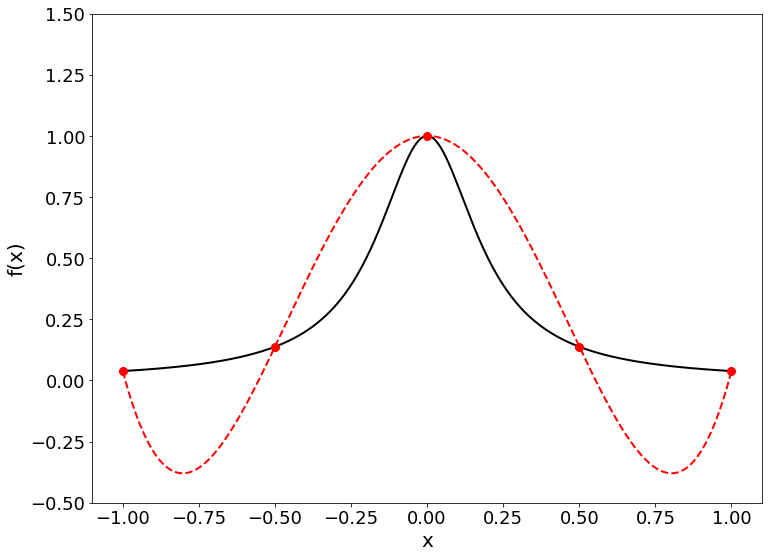

In [17]:
def runge(x): #Runge's example function
    return 1.0/(1 + 25*x**2)

def cheby_nodes(num): #in [-1,1]
    return np.array([-np.cos(np.pi*(2*j+1)/(2*num)) for j in range(0,num)])

degree = 4 # degree of interpolant
nodes = np.linspace(-1, 1, degree+1)
yvals = runge(nodes) #use numpy's vector arithmetic

x = np.linspace(-1,1,500)
y_true = runge(x)
y_interp = interp(nodes,yvals,x,'n')

plt.figure(1,figsize=fsize)
plt.plot(x,y_true,'-k')
plt.plot(x,y_interp,'--r')
plt.plot(nodes, runge(nodes),'.r')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim([-0.5,1.5]);

#### With the Chebyshev nodes...
The interpolant converges (uniformly) as $n$ increases when the Chebyshev nodes are used.


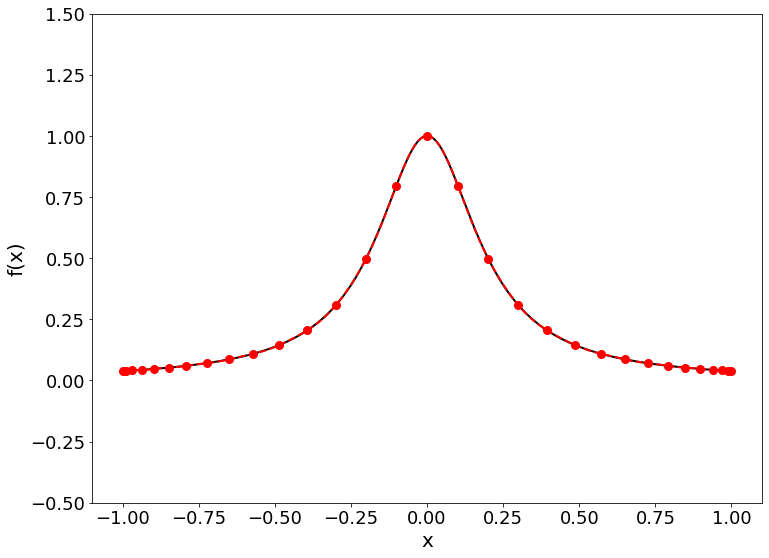

In [18]:
degree = 30 #degree of interplant
x = np.linspace(-1,1,500)
nodes = cheby_nodes(degree+1) #use Chebyshev
yvals = runge(nodes)
y_interp = interp(nodes,yvals,x,'n')
y_ml = interp(nodes,yvals,x,'bary')

plt.figure(1,figsize=fsize)
plt.plot(x,runge(x),'-k')
plt.plot(x,y_interp,'--r')
plt.plot(nodes, yvals,'.r')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim([-0.5,1.5]);

#### Plotting the error

Plotting the error gives more detail: 

- with equally spaced nodes, the error grows exponentially (straight line on a semi-log plot).
- with Chebyshev nodes, the error decays exponentially.
- For the Chebyshev nodes, the convergence is spoiled by rounding error (at $n\approx 60$) in the Newton form.
- However, the barycentric form is more numerically stable here; it has no rounding error issues.

An example is shown below.

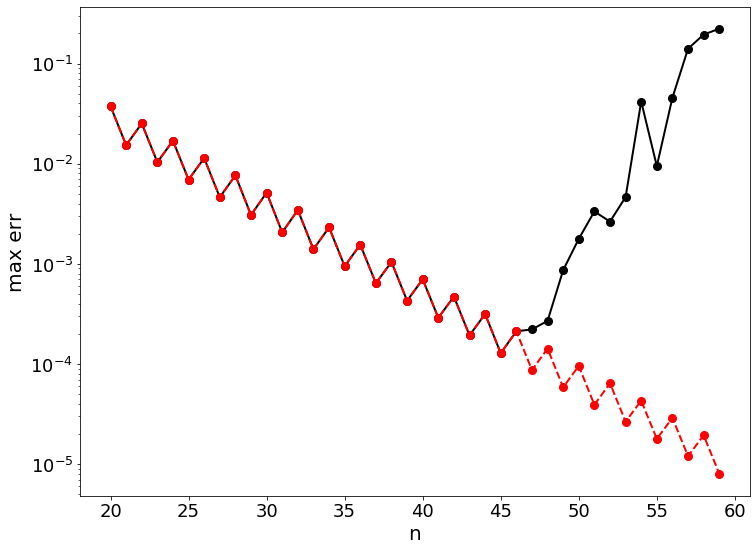

In [22]:
def max_error(x,y):
    mv = 0;
    for k in range(0,len(x)):
        mv = max(mv,abs(x[k] - y[k]))
    return mv

x = np.linspace(-1,1,300)
y_true = runge(x)

kvals = range(20,60,1)
merr_n = [0]*len(kvals)
merr_bary = [0]*len(kvals)
for i in range(0,len(kvals)):
    nodes = cheby_nodes(kvals[i])
    #nodes = equal_nodes(kvals[i])
    yvals = runge(nodes)
    y_interp = interp(nodes,yvals,x,'n')
    y_ml = interp(nodes,yvals,x,'bary')
    
    merr_n[i] = max_error(y_true, y_interp)
    merr_bary[i] = max_error(y_true, y_ml)
    
plt.figure(1,figsize=fsize)
plt.semilogy(kvals,merr_n,'.-k')
plt.semilogy(kvals,merr_bary,'.--r')
plt.xlabel('n')
plt.ylabel('max err');
    